In [483]:
from natsort import natsorted
from skimage.transform import resize
import glob
import numpy as np
from tifffile import imread
from skimage import io, morphology
import skimage
from scipy import ndimage as ndi
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, segmentation, measure, draw
from PIL import Image

In [134]:
def binarize_neg(image, radius, min_size):
    dapi = skimage.img_as_ubyte(image)
    # slower than optimized disk in ImageJ
    # scipy.ndimage.uniform_filter with square is fast but crappy
    selem = skimage.morphology.disk(radius)
    mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
    mask = dapi < mean_filtered
    mask = skimage.morphology.remove_small_objects(mask, min_size=min_size)

    return mask

def filter_by_region(labeled, score, threshold, intensity_image=None, relabel=True):
    labeled = labeled.copy().astype(int)
    regions = skimage.measure.regionprops(labeled, intensity_image=intensity_image)
    scores = np.array([score(r) for r in regions])

    if all([s in (True, False) for s in scores]):
        cut = [r.label for r, s in zip(regions, scores) if not s]
    else:
        t = threshold
        cut = [r.label for r, s in zip(regions, scores) if s < t]

    labeled.flat[np.in1d(labeled.flat[:], cut)] = 0
    
    if relabel:
        labeled, _, _ = skimage.segmentation.relabel_sequential(labeled)

    return labeled

def apply_watershed(img, smooth=4):
    distance = ndi.distance_transform_edt(img)
    if smooth > 0:
        distance = skimage.filters.gaussian(distance, sigma=smooth)
    local_max = skimage.feature.peak_local_max(
                    distance, indices=False, footprint=np.ones((3, 3)), 
                    exclude_border=False)

    markers = ndi.label(local_max)[0]
    result = skimage.segmentation.watershed(-distance, markers, mask=img)
    return result.astype(np.uint16) 

def find_cell(dapi, threshold, radius=10, area_min=50, area_max=500,
                score=lambda r: r.mean_intensity,
                smooth=1.35):
    """
    
    """

    mask = binarize_neg(dapi, radius, area_min)
    labeled = skimage.measure.label(mask)

    labeled = filter_by_region(labeled, lambda r: r.mean_intensity*2, threshold, intensity_image=dapi) > 0

    # only fill holes below minimum area
    filled = ndi.binary_fill_holes(labeled)
    difference = skimage.measure.label(filled!=labeled)

    change = filter_by_region(difference, lambda r: r.area < area_min, 0) > 0
    labeled[change] = filled[change]

    nuclei = apply_watershed(labeled, smooth=smooth)

    result = filter_by_region(nuclei, lambda r: area_min < r.area < area_max, threshold)
    
    return result

In [135]:
def correlate_channels(r, first, second):
    A, B = r.intensity_image_full[[first, second]]

    filt = A > 0
    if filt.sum() == 0:
        return np.nan

    A = A[filt]
    B  = B[filt]
    corr = (A - A.mean()) * (B - B.mean()) / (A.std() * B.std())

    return corr.mean()

In [1363]:
def process_background(list_bfp, sigma = 75):
    list_bfp_arrays = []
    for x in list_bfp:
        list_bfp_arrays.append(np.array(imread([x])).astype(np.int16))
    
    control_bfp = np.mean(list_bfp_arrays, axis = 0).astype(np.int16)
    control_bfp_norm = exposure.rescale_intensity(control_bfp, in_range=(control_bfp.min(), 
                                                                       control_bfp.max()), out_range=(0, 1))
    background = gaussian_filter(control_bfp_norm, sigma=sigma)
    
    return background

In [1370]:
def process_std_objects(path_bright, path_bfp, nucleus_area, background):

    data = np.array(imread(path_bright)).astype(np.int16)
    data = np.expand_dims(data, axis=2)
    
    data_bfp = np.array(imread(path_bfp)).astype(np.int16)
    data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

    data_bfp_norm = data_bfp[:,:] - background
    data_bfp_norm = exposure.rescale_intensity(data_bfp_norm, in_range=(data_bfp_norm.min(), 
                                                                        data_bfp_norm.max()), out_range=(0, 1))
    data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)

    combined_array = np.concatenate((data, data_bfp_norm), axis=2)

    intensity_image = combined_array[:,:]

    thresh = skimage.filters.threshold_otsu(data[:,:,0])
    
    cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
    props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

    list_std = []

    list_cell = []
    list_label = []
    list_intensity_bright =[]
    list_intensity_bfp = []
    list_intensity_corr = []
    list_intensity_sub = []

    score_label = lambda r: r.label
    score_intensityValue = lambda r: r.mean_intensity

    for region in props:
        b = region.bbox
        border = 5
        ## Making new region properties
        region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
        region.std = np.std(intensity_image[b[0]-border:b[2]+border, b[1]-border:b[3]+border, 1])
        list_std.append(region.std)
        list_cell.append(score_label(region))
        list_label.append(path_bright.split("/")[-1].split(".")[0])
        list_intensity_bfp.append(score_intensityValue(region)[1])

    std = np.array(list_std)
    cleaned_std = std[~np.isnan(std)]
    list_std_score_median =[]
    
    for region in props:
        region.std_median_center = region.std - np.median(cleaned_std)
        list_std_score_median.append(region.std_median_center)
    
    return (pd.DataFrame(zip(list_label, list_cell, list_std_score_median), columns = ["condition", "cell_number", 
                                                                                       "std_median_centered"]))

In [1412]:
list_bright = ["/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/5/5_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/5/5_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/5/5_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/7/7_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/7/7_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/7/7_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/8/8_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/8/8_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/8/8_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/9/9_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/9/9_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/9/9_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/10/10_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/10/10_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/10/10_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_2.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_3.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif",
              "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_3.resize.tif"]

In [1413]:
list_bfp = ["/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/5/5_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/5/5_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/5/5_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/7/7_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/7/7_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/7/7_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/8/8_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/8/8_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/8/8_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/9/9_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/9/9_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/9/9_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/10/10_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/10/10_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/10/10_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_3_bfp.tif"]

In [1414]:
list_bfp_control =["/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_1_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_2_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3_bfp.tif",
           "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1_bfp.tif",
            "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_2_bfp.tif"]

## Example Segmentation/Phenotyping

In [1715]:
background = process_background(list_bfp_control, sigma = 75)

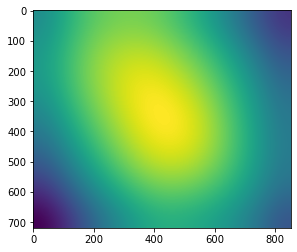

In [1716]:
plt.imshow(background)

In [1717]:
path_bright = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_bfp = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"

data = np.array(imread(path_bright)).astype(np.int16)
data = np.expand_dims(data, axis=2)

data_bfp = np.array(imread(path_bfp)).astype(np.int16)
data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

data_bfp_norm = data_bfp[:,:] - background
data_bfp_norm = exposure.rescale_intensity(data_bfp_norm, in_range=(data_bfp_norm.min(), 
                                                                    data_bfp_norm.max()), out_range=(0, 1))
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)

combined_array = np.concatenate((data, data_bfp_norm), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

list_std = []

list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity

for region in props:
    b = region.bbox
    border = 5
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.std = np.std(intensity_image[b[0]-border:b[2]+border, b[1]-border:b[3]+border, 1])
    list_std.append(region.std)
    list_cell.append(score_label(region))
    list_label.append(path_bright.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])

std = np.array(list_std)
cleaned_std = std[~np.isnan(std)]
list_std_score_median =[]

for region in props:
    region.std_median_center = region.std - np.median(cleaned_std)
    list_std_score_median.append(region.std_median_center)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,

## Brightfield Processing

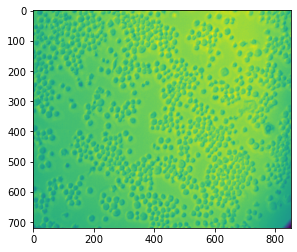

In [1719]:
plt.imshow(data)

### Segmented Cells

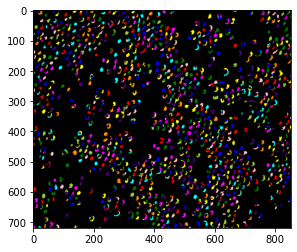

In [1721]:
plt.imshow(label2rgb(cells))

### BFP image processing

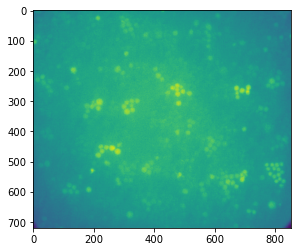

In [1722]:
plt.imshow(data_bfp)

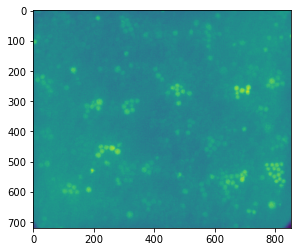

In [1718]:
plt.imshow(data_bfp_norm)

## Thresholding Phenotype (median centered standard deviation)

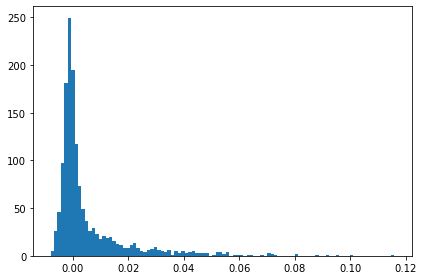

In [1724]:
plt.hist(list_std_score_median,bins = 100)
plt.tight_layout()

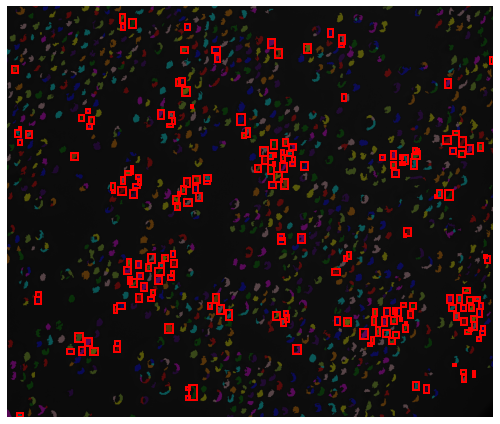

In [1723]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.std_median_center> .015:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/BFP_positive.1_1.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

## Process MOI Calcs

In [1415]:
df_moi = pd.DataFrame()
bg = process_background(list_bfp_control, sigma = 75)

for x in range(len(list_bfp)):
    df_temp = process_std_objects(list_bright[x], list_bfp[x], nucleus_area, bg)
    df_moi = pd.concat([df_moi, df_temp], ignore_index=True)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakeqiu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,

In [1436]:
df_moi.groupby("condition").count()

cell_number  std_median_centered
condition                                  
10_1              1679                 1636
10_2              1480                 1445
10_3              1780                 1742
11_1              1581                 1549
11_2              1311                 1289
11_3               861                  832
12_1              1482                 1442
12_3              1531                 1481
1_1               1015                  984
1_2               1446                 1413
1_3                939                  922
2_1               1864                 1818
2_2               1197                 1175
4_1               1136                 1116
4_2               2099                 2049
4_3               1667                 1626
5_1               1398                 1352
5_2               1889                 1851
5_3               1692                 1654
6_1               2494                 2422
6_2               1877                 1826
6_3               2210                 2163
7_1               1830                 1793
7_2               1937                 1892
7_3               1385                 1345
8_1               1792                 1751
8_2               1292                 1265
8_3               1168                 1145
9_1               2067                 2028
9_2               1821                 1771
9_3               2033                 1976

In [1456]:
threshold = 0.015
def count_threshold(values):
    return (values >threshold).sum()

In [1457]:
df_moi_cell_total = df_moi.groupby("condition").count().rename(columns ={"std_median_centered": "cell_count_total"})

In [1458]:
df_moi_bfp = df_moi.groupby("condition").apply(count_threshold).rename(columns = {"std_median_centered":"bfp_positive_cells"})

In [1459]:
df_moi_merge = pd.merge(df_moi_cell_total, df_moi_bfp, left_index=True, right_index=True)

In [1460]:
df_moi_merge.drop(columns = ["cell_number_x", "cell_number_y"], inplace = True)

In [1462]:
df_moi_merge['fraction_infected'] = df_moi_merge.bfp_positive_cells/df_moi_merge.cell_count_total

In [1469]:
df_moi_merge.reset_index(inplace = True)

In [1477]:
df_moi_merge["well"] = df_moi_merge.condition.apply(lambda x : x.split("_")[0]).astype(int)

In [1480]:
df_moi_well = df_moi_merge.groupby("well").mean()

In [1512]:
df_moi_well

cell_count_total  bfp_positive_cells  fraction_infected  \
well                                                            
1          1106.333333            1.333333           0.001446   
2          1496.500000            4.500000           0.002927   
4          1597.000000            0.333333           0.000163   
5          1619.000000            1.666667           0.000988   
6          2137.000000            4.333333           0.002170   
7          1676.666667            4.000000           0.002440   
8          1387.000000            6.666667           0.005584   
9          1925.000000           22.333333           0.011181   
10         1607.666667           38.333333           0.024198   
11         1223.333333           72.333333           0.061458   
12         1461.500000          202.500000           0.138595   

      uninfected_cells  
well                    
1          1105.000000  
2          1492.000000  
4          1596.666667  
5          1617.333333  
6          2132.666667  
7          1672.666667  
8          1380.333333  
9          1902.666667  
10         1569.333333  
11         1151.000000  
12         1259.000000

In [1499]:
df_moi_well["uninfected_cells"] = df_moi_well.cell_count_total - df_moi_well.bfp_positive_cells

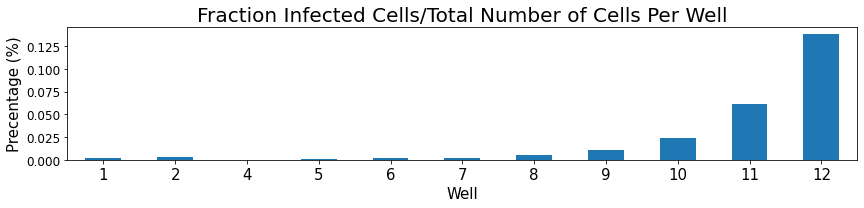

In [1681]:
plt.figure(figsize = (12,3))
df_moi_well.fraction_infected.plot(kind = "bar")
plt.title("Fraction Infected Cells/Total Number of Cells Per Well", size = 20)
plt.ylabel("Precentage (%)", size = 15)
plt.xticks(size = 15, rotation = 0)
plt.xlabel("Well", size = 15)
plt.yticks(size = 12)
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/fraction_cells.jpeg")

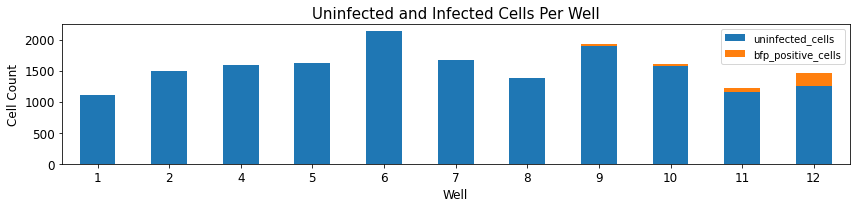

In [1684]:

df_moi_well[["uninfected_cells", "bfp_positive_cells"]].plot(kind = "bar", stacked = True, figsize = (12,3))
plt.title("Uninfected and Infected Cells Per Well", size = 15)
plt.ylabel("Cell Count", size = 12)
plt.xticks(size = 12, rotation = 0)
plt.xlabel("Well", size = 12)
plt.yticks(size = 12)
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/total_cells_bar.jpeg")

In [1517]:
def poisson_MOI(moi, k):
    return((np.exp(-moi)*np.power(moi,k))/np.math.factorial(k))

In [1617]:
seq_k = np.arange(0,6,1)

In [1639]:
seq_moi = [.05,.1,.2,.3,.5,1,2,5,10]

In [1657]:
list_poisson = []
list_moi = []
list_k = []

for x in seq_moi:
    for y in seq_k:
        list_poisson.append(poisson_MOI(x,y))
        list_moi.append(x)
        list_k.append(y)

In [1658]:
df_poisson_moi_0 = pd.DataFrame(zip(list_poisson,list_moi,list_k), columns = ["poisson", "moi", "k"])

In [1620]:
df_poisson_moi_p3 = pd.DataFrame(zip(list_poisson,list_moi,list_k), columns = ["poisson", "moi", "k"])

In [1573]:
df_poisson_moi = pd.DataFrame(zip(list_poisson,list_moi,list_k), columns = ["poisson", "moi", "k"])

In [1576]:
# Calculate the group sum
group_sum = df_poisson_moi.groupby('moi')['poisson'].transform('sum')
df_poisson_moi["multiple_integrants"] = 1 - group_sum


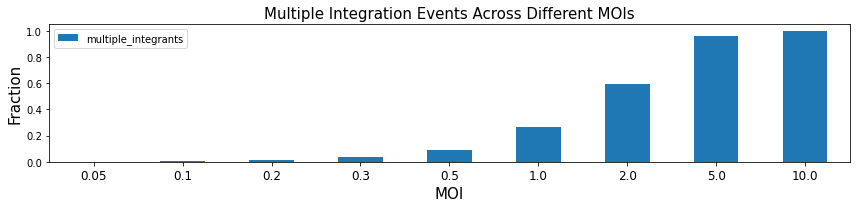

In [1689]:
df_poisson_moi.groupby("moi")["multiple_integrants"].mean().to_frame().plot(kind = "bar", figsize = (12,3))
plt.title("Multiple Integration Events Across Different MOIs", size = 15)
plt.xlabel("MOI", size = 15)
plt.xticks(size = 12, rotation = 0)
plt.ylabel("Fraction", size = 15)
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/moi/output/multiple_integrant.jpeg")

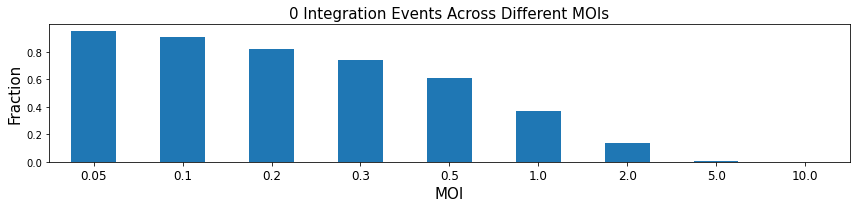

In [1688]:
df_poisson_moi[df_poisson_moi.k == 0].set_index("moi").poisson.plot(kind = "bar", figsize = (12,3))
plt.title("0 Integration Events Across Different MOIs", size = 15)
plt.xlabel("MOI", size = 15)
plt.xticks(size = 12, rotation = 0)
plt.ylabel("Fraction", size = 15)
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/moi/output/zero_integrant.jpeg")

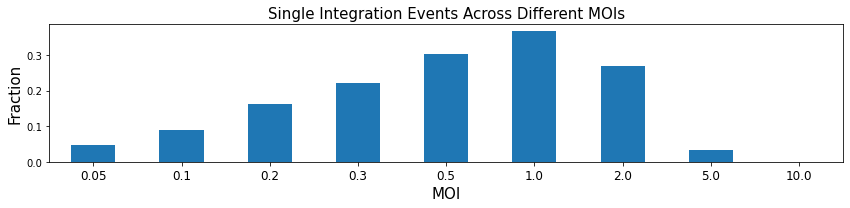

In [1687]:
df_poisson_moi[df_poisson_moi.k == 1].set_index("moi").poisson.plot(kind = "bar", figsize = (12,3))
plt.title("Single Integration Events Across Different MOIs", size = 15)
plt.xlabel("MOI", size = 15)
plt.xticks(size = 12, rotation = 0)
plt.ylabel("Fraction", size = 15)
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/moi/output/single_integrant.jpeg")

In [1625]:
# Create a new row
new_row = {'poisson': 1 - df_poisson_moi_p3.poisson.sum(), 'moi': 0.3, "k": ">5"}

# Add the new row using loc
df_poisson_moi_p3.loc[len(df_poisson_moi_p3)] = new_row

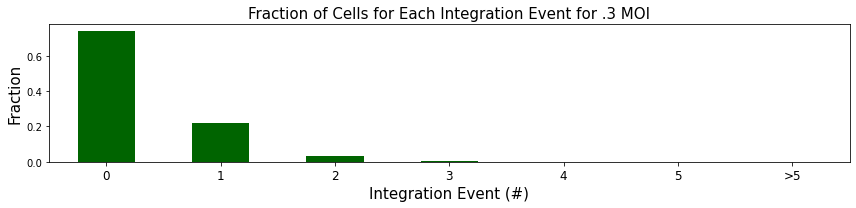

In [1686]:
df_poisson_moi_p3.set_index("k").poisson.plot(kind = "bar", figsize = (12,3),color = "darkgreen")
plt.title("Fraction of Cells for Each Integration Event for .3 MOI", size = 15)
plt.xlabel("Integration Event (#)", size = 15)
plt.xticks(size = 12, rotation = 0)
plt.ylabel("Fraction", size = 15)
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/moi/output/MOI_p3_integrant.jpeg")

In [1660]:
group_sum = df_poisson_moi_0.groupby('moi')['poisson'].transform('sum')
df_poisson_moi_0["all_integrants"] = 1 - group_sum

In [1666]:
df_poisson_moi_0.index = df_poisson_moi_0.set_index("moi").index.map(lambda x: f'{x:.2f}')

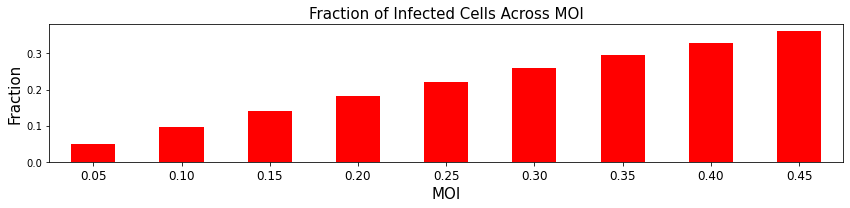

In [1685]:
df_poisson_moi_0.all_integrants.plot(kind = "bar", figsize = (12,3),color = "red")
plt.title("Fraction of Infected Cells Across MOI", size = 15)
plt.xlabel("MOI", size = 15)
plt.xticks(size = 12, rotation = 0)
plt.ylabel("Fraction", size = 15)
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/moi/output/infected_cells_integrant.jpeg")

# Trash

# Trash

# Trash

In [327]:
data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

corr_img = correlation_measure(data[:,:], data_bfp[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp[:,:])

data = np.expand_dims(data, axis=2)
data_bfp = np.expand_dims(data_bfp, axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


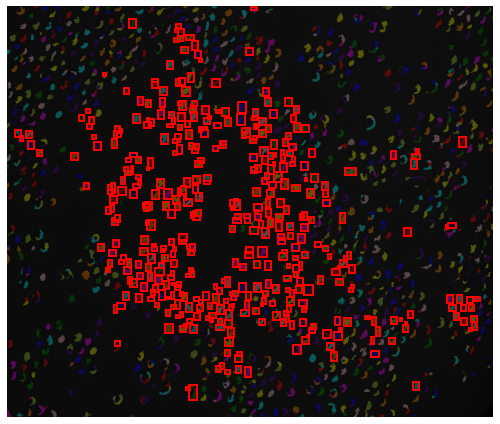

In [366]:
import matplotlib.patches as mpatches
threshold_intensity = 2100
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.intensity_mean[1] >= 2000 and region.intensity_mean[3] <= 0 and region.intensity_mean[2] > 500:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Controls

#### BFP Norming

In [429]:
path_control1="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_1_bfp.tif"
path_control2="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_2_bfp.tif"
path_control3="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3_bfp.tif"
path_control4="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1_bfp.tif"
path_control5="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_2_bfp.tif"
path_control6 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_3_bfp.tif"

data_control_1 = np.array(imread(path_control1)).astype(np.int16)
data_control_2 = np.array(imread(path_control2)).astype(np.int16)
data_control_3 = np.array(imread(path_control3)).astype(np.int16)
data_control_4 = np.array(imread(path_control4)).astype(np.int16)
data_control_5 = np.array(imread(path_control5)).astype(np.int16)
data_control_6 = np.array(imread(path_control6)).astype(np.int16)

data_control_mean = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

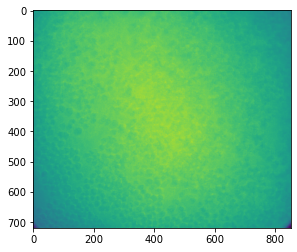

In [432]:
plt.imshow(data_control_mean)

In [487]:
data_bfp_norm = data_bfp[:,:] - data_control_mean

In [488]:
im = Image.fromarray(data_bfp_norm)
im.save("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/12_1_bfp.norm.tiff")

In [489]:
im = Image.fromarray(data_control_mean)
im.save("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/control_bfp.norm.tiff")

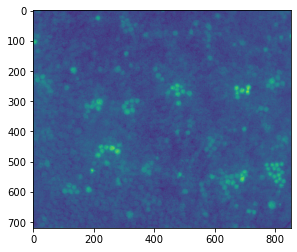

In [434]:
plt.imshow(data_bfp_norm)

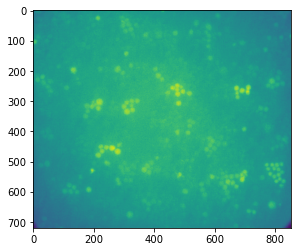

In [436]:
plt.imshow(data_bfp[:,:])

#### Brightfield Norming

In [420]:
path_control1_b="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_1.resize.tif"
path_control2_b="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_2.resize.tif"
path_control3_b="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3.resize.tif"
path_control4_b="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1.resize.tif"
path_control5_b="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_2.resize.tif"
path_control6_b = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_3.resize.tif"

In [421]:
data_control_1_b = np.array(imread(path_control1_b)).astype(np.int16)
data_control_2_b = np.array(imread(path_control2_b)).astype(np.int16)
data_control_3_b = np.array(imread(path_control3_b)).astype(np.int16)
data_control_4_b = np.array(imread(path_control4_b)).astype(np.int16)
data_control_5_b = np.array(imread(path_control5_b)).astype(np.int16)
data_control_6_b = np.array(imread(path_control6_b)).astype(np.int16)

In [422]:
data_control_mean_b = np.mean([data_control_1_b, data_control_2_b, data_control_3_b, data_control_4_b,
                            data_control_5_b, data_control_6_b], axis = 0).astype(np.int16)

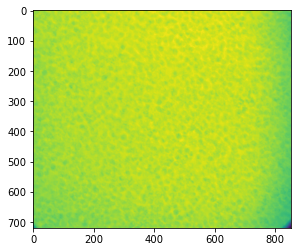

In [423]:
plt.imshow(data_control_mean_b)

In [425]:
data_bright_norm = data[:,:] - data_control_mean_b

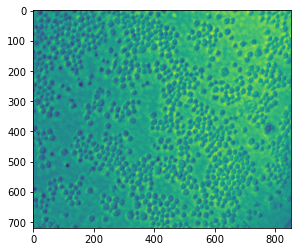

In [426]:
plt.imshow(data_bright_norm)

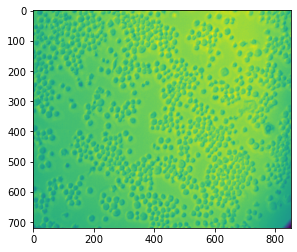

In [428]:
plt.imshow(data[:,:])

#### Processing Skimage objects

In [394]:
thresh = skimage.filters.threshold_otsu(data_bright_norm)

In [395]:
thresh

151

In [417]:
data.shape

(720, 852)

In [418]:
combined_array.shape

(720, 852, 4, 1, 1)

In [419]:
data_bright_norm.shape

(720, 852, 1, 1, 1)

In [601]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
#data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)
#data_bfp_norm = data_bfp[:,:] - data_control_mean_bfp

corr_img = correlation_measure(data[:,:], normalized_images[0,:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], normalized_images[0,:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(normalized_images[0,:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


In [602]:
region.zscore

0.5621269584848353

In [587]:
thresh = skimage.filters.threshold_otsu(data_bfp_norm[:,:,0])

In [588]:
thresh

0.21932988376835233

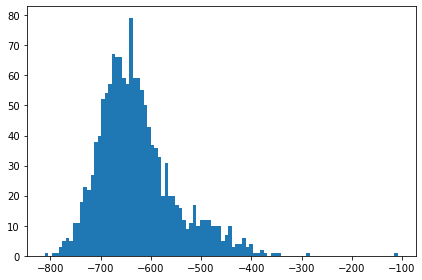

In [555]:
plt.hist(list_intensity_bfp, bins = 100)
plt.tight_layout()

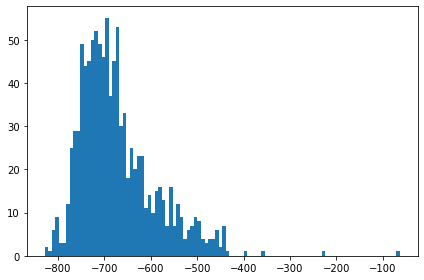

In [553]:
plt.hist(list_intensity_bfp, bins = 100)
plt.tight_layout()

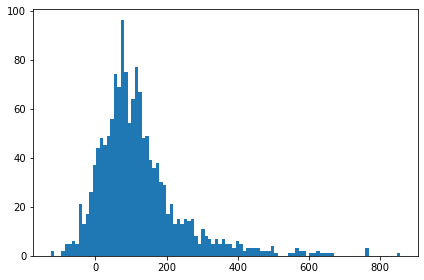

In [551]:
plt.hist(list_intensity_bfp, bins = 100)
plt.tight_layout()

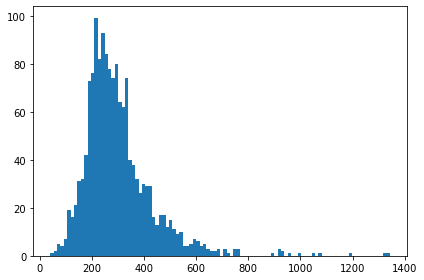

In [549]:
plt.hist(list_intensity_bfp, bins = 100)
plt.tight_layout()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  2.,  2.,  2.,  4.,  3.,  5., 12., 14., 10., 10.,
        18., 21., 22., 22., 26., 27., 20., 35., 38., 46., 53., 57., 56.,
        62., 58., 70., 59., 52., 44., 45., 40., 45., 41., 28., 37., 28.,
        23., 29., 13., 21., 13., 15., 12., 10.,  9.,  6.,  2.,  3.,  0.,
         2.,  4.,  2.,  4.,  2.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([-76.72727273, -72.05609375, -67.38491477, -62.7137358 ,
        -58.04255682, -53.37137784, -48.70019886, -44.02901989,
        -39.35784091, -34.68666193, -30.01548295, -25.34430398,
        -20.673125  , -16.00194602, -11.33076705,  -6.65958807,
         -1.98840909,   2.68276989,   7.35394886,  12.02512784,
         16.69630682,  21.3674858 ,  26.03866477,  30.70984375,
         35.38102273,  40.0522017 ,  44.72338068, 

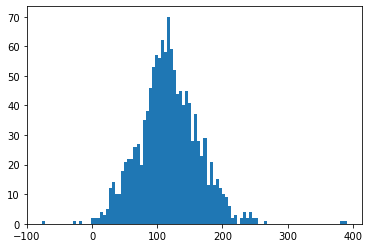

In [547]:
plt.hist(list_intensity_bfp, bins = 100)

In [577]:
threshold

0.6579896513050569

In [642]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)
data_bfp_norm = data_bfp[:,:] - data_control_mean_bfp

corr_img = correlation_measure(data[:,:], data_bfp[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


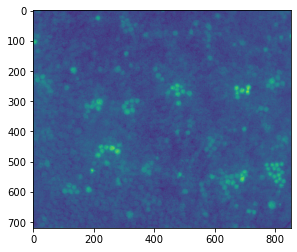

In [643]:
plt.imshow(data_bfp_norm)

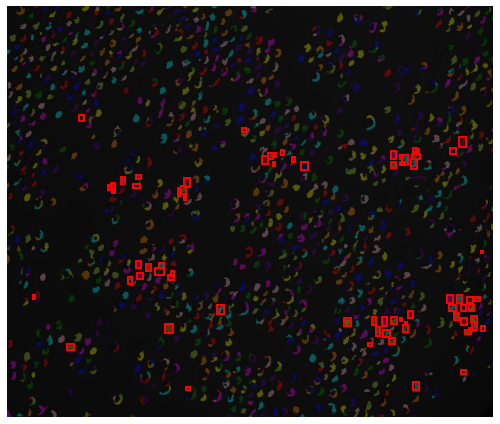

In [645]:
import matplotlib.patches as mpatches
threshold = thresh*3
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 2:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

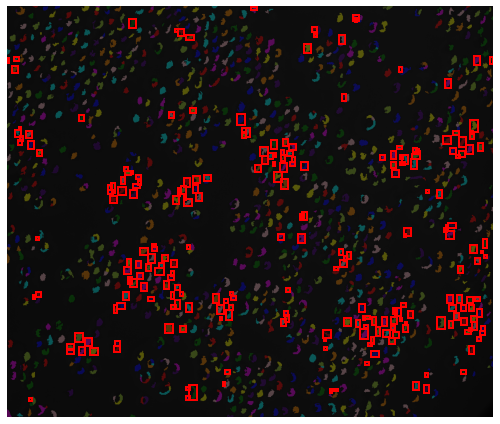

In [598]:
import matplotlib.patches as mpatches
threshold = thresh*3
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.intensity_mean[1] >= .25:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

In [646]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_3.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_3_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)
data_bfp_norm = data_bfp[:,:] - data_control_mean_bfp

corr_img = correlation_measure(data[:,:], data_bfp[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


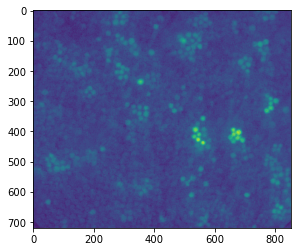

In [647]:
plt.imshow(data_bfp_norm)

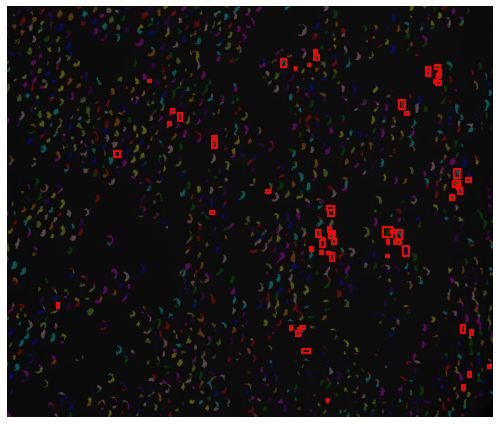

In [648]:
import matplotlib.patches as mpatches
threshold = thresh*3
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 2:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

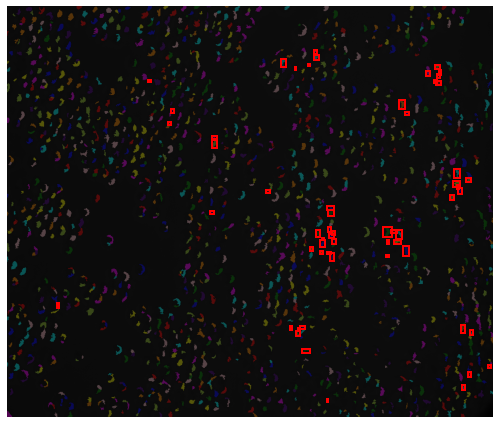

In [595]:
import matplotlib.patches as mpatches
threshold = thresh*3
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.intensity_mean[1] >= .4:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

In [668]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_1_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_bfp_norm = data_bfp[:,:] - data_control_mean_bfp

corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


In [656]:
from scipy.ndimage.filters import gaussian_filter

blurred = gaussian_filter(data_control_mean_bfp, sigma=7)

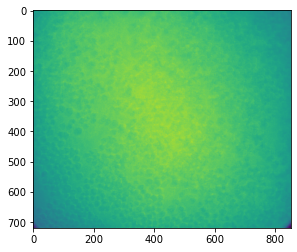

In [654]:
plt.imshow(data_control_mean_bfp)

In [657]:
from scipy.ndimage.filters import gaussian_filter

blurred = gaussian_filter(data_control_mean_bfp, sigma=7)

In [662]:
blurred.min()

527

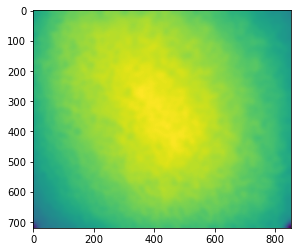

In [658]:
plt.imshow(blurred)

In [665]:
min_val = np.min(data_control_mean_bfp)
max_val = np.max(data_control_mean_bfp)

In [666]:
data_control_mean_bfp_norm = exposure.rescale_intensity(data_control_mean_bfp, in_range=(min_val, max_val), out_range=(0, 1))

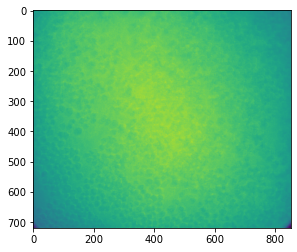

In [667]:
plt.imshow(data_control_mean_bfp_norm)

In [664]:
data_bfp.min()

284

In [663]:
data_bfp.max()

1992

In [670]:
data_bfp_norm_2 = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

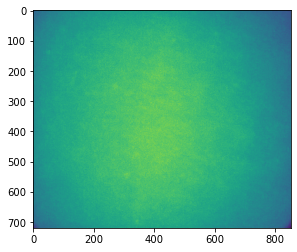

In [669]:
plt.imshow(data_bfp)

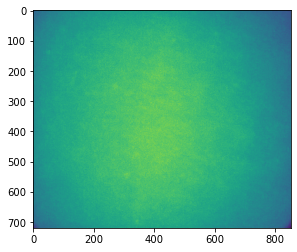

In [671]:
plt.imshow(data_bfp_norm_2)

In [672]:
data_norm = data_bfp_norm_2 - data_control_mean_bfp_norm

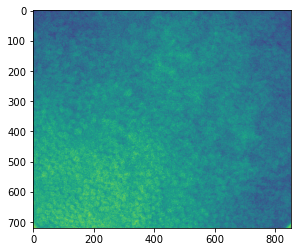

In [673]:
plt.imshow(data_norm)

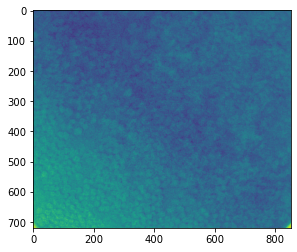

In [651]:
plt.imshow(data_bfp_norm)

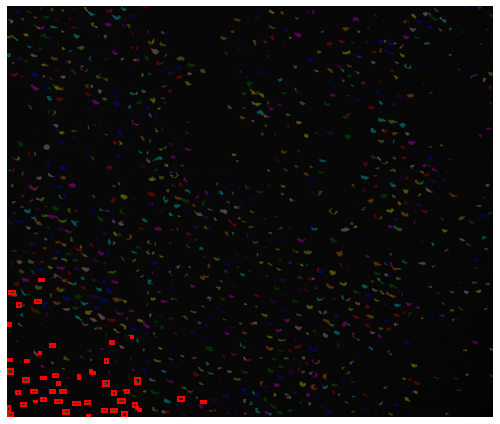

In [653]:
threshold = thresh*3
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 2:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

### norm different method

#### 12_1

In [920]:
### Include the cells from 1 and 2

In [893]:
blurred = gaussian_filter(data_control_mean_bfp, sigma=50)

In [906]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

data_bfp_norm = data_bfp[:,:] - blurred

corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


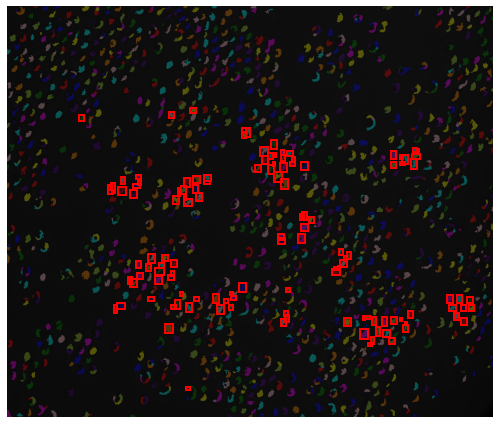

In [919]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 1.25:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

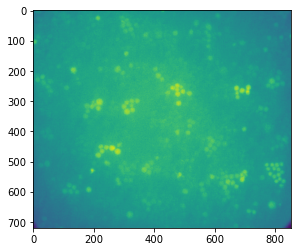

In [915]:
plt.imshow(data_bfp)

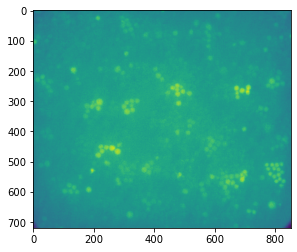

In [914]:
plt.imshow(data_bfp_norm)

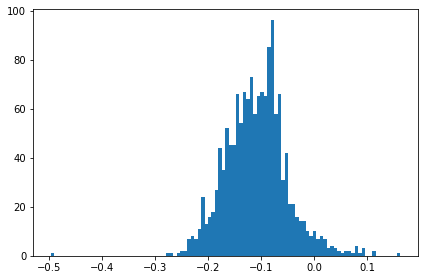

In [918]:
plt.hist(list_intensity_bfp, bins = 100)
plt.tight_layout()

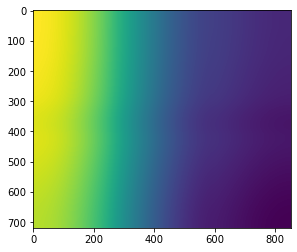

In [847]:
plt.imshow(blurred)

In [902]:
blurred = gaussian_filter(data_control_mean_bfp, sigma=200)

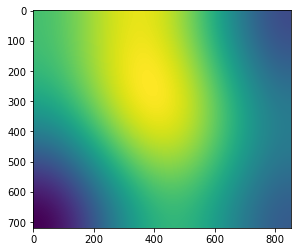

In [903]:
plt.imshow(blurred)

In [904]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_3.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_3_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

data_bfp_norm = data_bfp[:,:] - blurred

corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


Blurred = 1

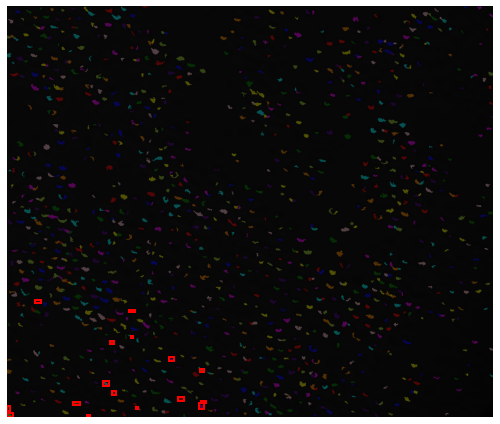

In [820]:
threshold = thresh*3
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 2:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

Blurred = 10

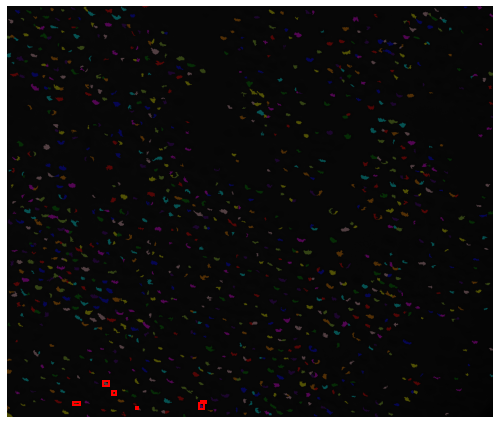

In [823]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 2:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

Blurred = 20

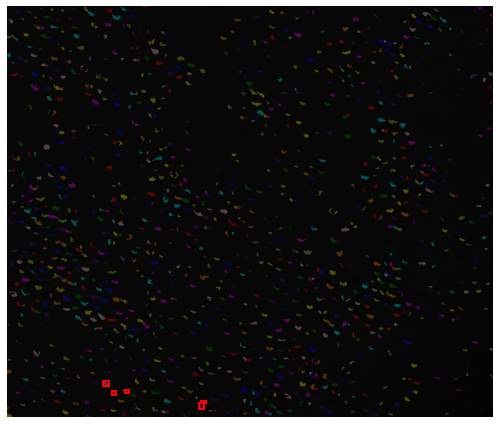

In [826]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 2:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

Blurred = 100

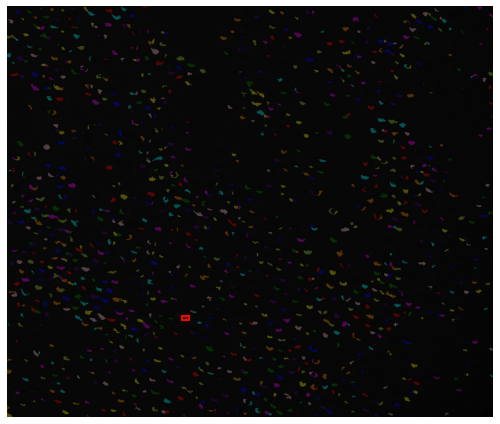

In [841]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 1.75:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

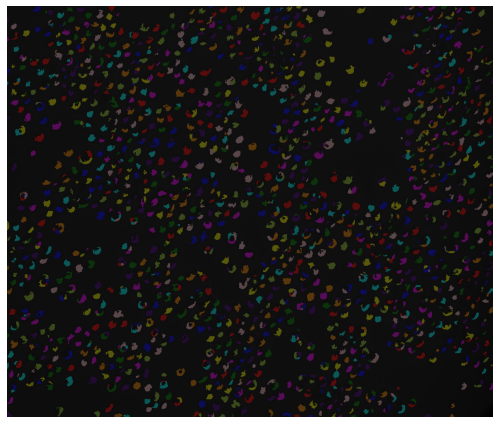

In [905]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 1.75:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

In [783]:
blurred = gaussian_filter(data_control_mean_bfp, sigma=10)

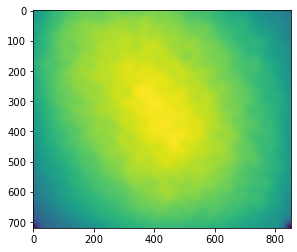

In [780]:
plt.imshow(blurred)

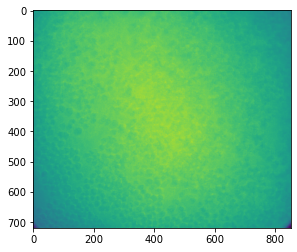

In [689]:
plt.imshow(data_control_mean_bfp)

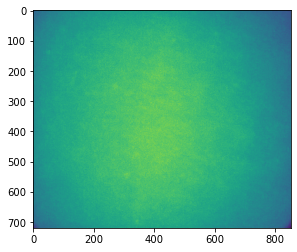

In [687]:
plt.imshow(data_bfp)

In [709]:
data_control_mean_bfp.max()

1.0

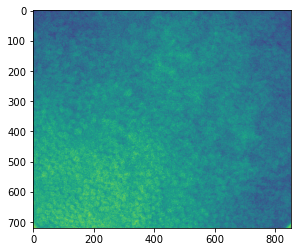

In [686]:
plt.imshow(data_bfp_norm)

In [690]:
data_bfp_norm.shape

(720, 852, 1)

In [692]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Create an empty numpy array
shape = (100, 100)  # Define the shape of the array
array = np.zeros(shape)

# Set the center coordinates of the array
center_x = shape[0] // 2
center_y = shape[1] // 2

# Set the standard deviation for the Gaussian distribution
sigma = 10

# Generate a Gaussian distribution centered around the center of the array
gaussian_array = np.exp(-((np.arange(shape[0]) - center_x) ** 2 + (np.arange(shape[1]) - center_y) ** 2) / (2 * sigma ** 2))

# Normalize the Gaussian array to have a maximum value of 1
gaussian_array /= np.max(gaussian_array)

In [755]:
# Create an empty numpy array
shape = (720, 852)  # Define the shape of the array
center_x = shape[1] / 2
center_y = shape[0] / 2

# Set the standard deviation for the Gaussian distribution
sigma = 2000

# Generate grid coordinates
x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

# Calculate distances from the center
dist = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

# Generate Gaussian distribution
gaussian_array = np.exp(-dist ** 2 / (2 * sigma ** 2))

# Normalize the Gaussian array to have a maximum value of 1
gaussian_array /= np.max(gaussian_array)


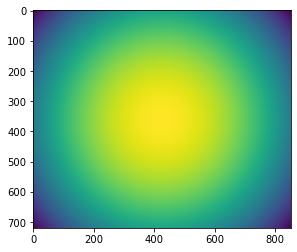

In [756]:
plt.imshow(gaussian_array)

### Combining Scores

In [964]:
list_bright = [path_control1_b, path_control2_b, path_control3_b, path_control4_b, path_control5_b, path_control6_b]
list_bfp = [path_control1, path_control2, path_control3, path_control4, path_control5, path_control6]

list_cells_control_bfp = []
list_cells_control_bright = []
for x in range(len(list_bright)):
    data = np.array(imread(list_bright[x])).astype(np.int16)
    data_bfp = np.array(imread(list_bfp[x])).astype(np.int16)

    data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                                data_control_5, data_control_6], axis = 0).astype(np.int16)

    data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                           data_control_mean_bfp.max()), out_range=(0, 1))

    data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

    blurred = gaussian_filter(data_control_mean_bfp, sigma=100)
    
    data_bfp_norm = data_bfp[:,:] - blurred

    corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
    corr_img = np.array(-corr_img* 1000).astype(np.int16)

    sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

    data = np.expand_dims(data, axis=2)
    data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
    corr_img = np.expand_dims(corr_img, axis=2)
    sub_img = np.expand_dims(sub_img, axis=2)

    combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

    intensity_image = combined_array[:,:]

    thresh = skimage.filters.threshold_otsu(data[:,:,0])

    cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
    props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

    for region in props:
        b = region.bbox
        ## Making new region properties
        region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]


    score_label = lambda r: r.label
    score_intensityValue = lambda r: r.mean_intensity
    for region in props:
        list_cell.append(score_label(region))
        list_cells_control_bfp.append(score_intensityValue(region)[1])
        list_cells_control_bright.append(score_intensityValue(region)[0])
        
    print(len(list_cell))


/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


2151
3597
4536
6400
7597
8907


In [974]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"
nucleus_area=(10,750)

list_cells_control_bfp_tmp = list_cells_control_bfp

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

data_bfp_norm = data_bfp[:,:] - blurred

corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    list_cells_control_bfp_tmp.append(score_intensityValue(region)[1])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_cells_control_bfp_tmp))/np.std(list_cells_control_bfp_12_1)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


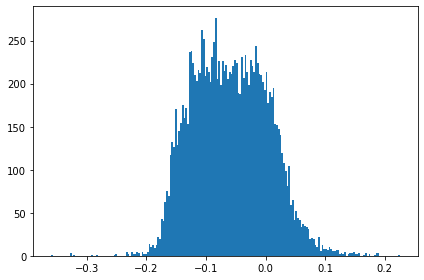

In [975]:
plt.hist(list_cells_control_bfp_12_1, bins = 200)
plt.tight_layout()

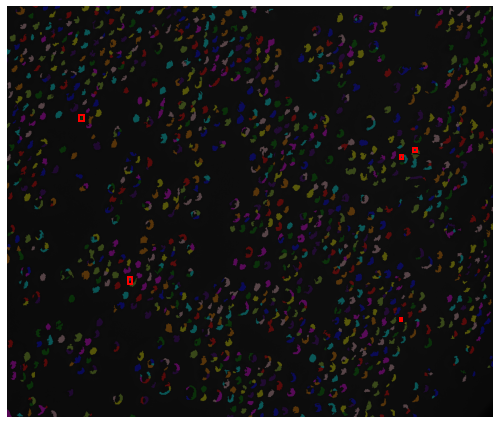

In [978]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 2:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

In [968]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/4/4_1_bfp.tif"
nucleus_area=(10,750)

list_cells_control_bfp_tmp = list_cells_control_bfp

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

data_bfp_norm = data_bfp[:,:] - blurred

corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    list_cells_control_bfp_tmp.append(score_intensityValue(region)[1])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_cells_control_bfp_tmp))/np.std(list_cells_control_bfp_12_1)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


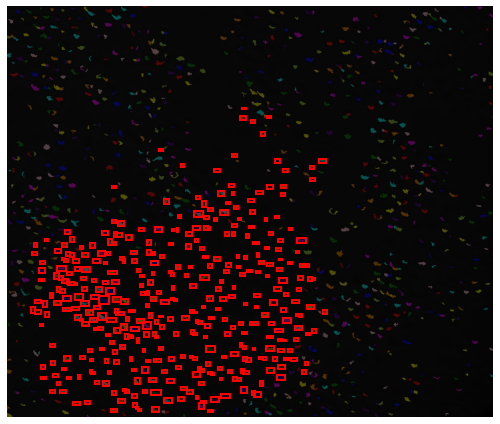

In [973]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.zscore >= 0:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

## T-test

In [1014]:
from scipy import stats

control_dist = np.array(list_cells_control_bfp)
# Define the hypothesized population mean
hypothesized_mean = 10

# Perform the one-sample t-test
stats.ttest_1samp(control_dist, control_dist.mean())[1]

1.0

In [1013]:
control_dist.mean()

-0.06315995869091277

In [981]:
p_value

0.0

In [1336]:
region.std 

0.0374334701709791

In [1343]:
(intensity_image[b[0]-border:b[2]+border, b[1]-border:b[3]+border, 0])

array([[1880., 1936., 1951., 2039., 2116., 2122., 2157., 2159., 2214.,
        2155., 2182., 2176., 2164., 2181., 2174., 2157., 2072., 2075.],
       [1919., 1921., 1959., 2041., 2048., 2092., 2140., 2159., 2140.,
        2154., 2142., 2153., 2143., 2151., 2147., 2108., 2158., 2124.],
       [1994., 2029., 2025., 2030., 2023., 2018., 2040., 2139., 2160.,
        2172., 2173., 2131., 2137., 2133., 2115., 2113., 2126., 2101.],
       [1999., 2003., 1999., 2039., 2000., 1983., 2024., 2104., 2119.,
        2118., 2090., 2102., 2132., 2142., 2171., 2154., 2124., 2127.],
       [2035., 2039., 2037., 2035., 1987., 1951., 1923., 1962., 2010.,
        2057., 2096., 2137., 2164., 2139., 2131., 2138., 2087., 2114.],
       [2070., 2067., 2019., 1988., 1971., 1901., 1913., 1928., 1945.,
        1996., 2049., 2090., 2119., 2134., 2138., 2108., 2126., 2113.],
       [2159., 2093., 2066., 2029., 1991., 1950., 1884., 1868., 1888.,
        1888., 1936., 1983., 2041., 2091., 2103., 2119., 2129., 2115.],

In [1345]:
matrix = np.matrix((intensity_image[b[0]-border:b[2]+border, b[1]-border:b[3]+border, 0]))

In [1347]:
df = pd.DataFrame(matrix)

In [1348]:
df

0       1       2       3       4       5       6       7       8   \
0   1880.0  1936.0  1951.0  2039.0  2116.0  2122.0  2157.0  2159.0  2214.0   
1   1919.0  1921.0  1959.0  2041.0  2048.0  2092.0  2140.0  2159.0  2140.0   
2   1994.0  2029.0  2025.0  2030.0  2023.0  2018.0  2040.0  2139.0  2160.0   
3   1999.0  2003.0  1999.0  2039.0  2000.0  1983.0  2024.0  2104.0  2119.0   
4   2035.0  2039.0  2037.0  2035.0  1987.0  1951.0  1923.0  1962.0  2010.0   
5   2070.0  2067.0  2019.0  1988.0  1971.0  1901.0  1913.0  1928.0  1945.0   
6   2159.0  2093.0  2066.0  2029.0  1991.0  1950.0  1884.0  1868.0  1888.0   
7   2169.0  2174.0  2147.0  2107.0  2022.0  1995.0  1902.0  1899.0  1844.0   
8   2219.0  2232.0  2196.0  2085.0  2021.0  2008.0  1928.0  1884.0  1876.0   
9   2196.0  2256.0  2197.0  2120.0  2040.0  1974.0  1894.0  1872.0  1788.0   
10  2245.0  2261.0  2172.0  2100.0  2015.0  1969.0  1947.0  1879.0  1794.0   

        9       10      11      12      13      14      15      16      17  
0   2155.0  2182.0  2176.0  2164.0  2181.0  2174.0  2157.0  2072.0  2075.0  
1   2154.0  2142.0  2153.0  2143.0  2151.0  2147.0  2108.0  2158.0  2124.0  
2   2172.0  2173.0  2131.0  2137.0  2133.0  2115.0  2113.0  2126.0  2101.0  
3   2118.0  2090.0  2102.0  2132.0  2142.0  2171.0  2154.0  2124.0  2127.0  
4   2057.0  2096.0  2137.0  2164.0  2139.0  2131.0  2138.0  2087.0  2114.0  
5   1996.0  2049.0  2090.0  2119.0  2134.0  2138.0  2108.0  2126.0  2113.0  
6   1888.0  1936.0  1983.0  2041.0  2091.0  2103.0  2119.0  2129.0  2115.0  
7   1816.0  1856.0  1901.0  2002.0  2130.0  2144.0  2125.0  2143.0  2120.0  
8   1814.0  1791.0  1880.0  1950.0  2069.0  2131.0  2169.0  2155.0  2141.0  
9   1773.0  1704.0  1775.0  1918.0  2005.0  2098.0  2198.0  2184.0  2188.0  
10  1723.0  1708.0  1774.0  1926.0  2026.0  2143.0  2174.0  2197.0  2180.0

In [1335]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"
nucleus_area=(10,750)

list_cells_control_bfp_tmp = list_cells_control_bfp

control_dist = np.array(list_cells_control_bfp_tmp)


data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

im = Image.fromarray(data_bfp)
im.save("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/original_12_1.tiff")
data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

im = Image.fromarray(data_bfp)
im.save("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/normed_12_1.tiff")
data_bfp_norm = data_bfp[:,:] - blurred
im = Image.fromarray(data_bfp_norm)
im.save("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/normed_subtracted_12_1.tiff")

data_bfp_norm = exposure.rescale_intensity(data_bfp_norm, in_range=(data_bfp_norm.min(), data_bfp_norm.max()), out_range=(0, 1))
corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

list_std = []
list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity

for region in props:
    b = region.bbox
    border = 5
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)
    region.std = np.std(intensity_image[b[0]-border:b[2]+border, b[1]-border:b[3]+border, 1])
    list_std.append(region.std)
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    list_cells_control_bfp_tmp.append(score_intensityValue(region)[1])  
std = np.array(list_std)
cleaned_std = std[~np.isnan(std)]
list_std_score = []
list_std_score_mean = []
list_std_score_median = []
for region in props:

    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)
    region.pval = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[1]
    region.tscore = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[0]
    region.std_mean_center = region.std - np.mean(cleaned_std)
    region.std_median_center = region.std - np.median(cleaned_std)
    region.std_zscore = (region.std - np.mean(cleaned_std))/np.std(cleaned_std)
    list_std_score.append(region.std_zscore)
    list_std_score_mean.append(region.std_mean_center)
    list_std_score_median.append(region.std_median_center)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


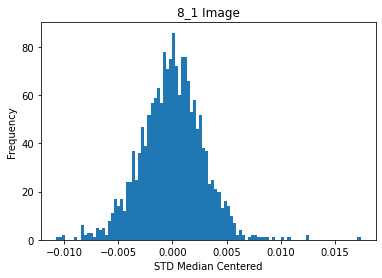

In [1334]:
plt.hist(list_std_score_median, bins = 100)
plt.title("8_1 Image")
plt.ylabel("Frequency")
plt.xlabel("STD Median Centered")
plt.tight_layout
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/std_median_centered_distribution.8_1.jpeg")

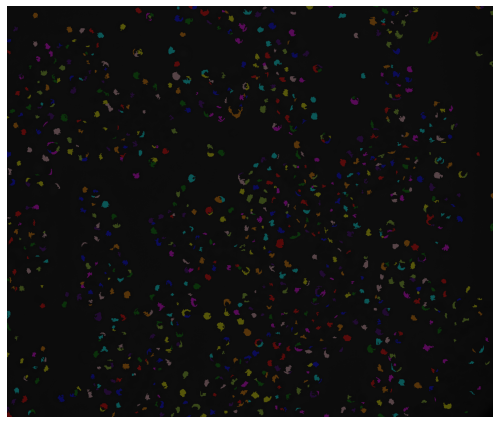

In [1332]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.std_median_center> .015:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/BFP_positive.1_1.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

In [1310]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/6/6_1_bfp.tif"
nucleus_area=(10,750)

list_cells_control_bfp_tmp = list_cells_control_bfp

control_dist = np.array(list_cells_control_bfp_tmp)


data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

data_bfp_norm = data_bfp[:,:] - blurred

data_bfp_norm = exposure.rescale_intensity(data_bfp_norm, in_range=(data_bfp_norm.min(), data_bfp_norm.max()), out_range=(0, 1))
corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

list_std = []
list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity

for region in props:
    b = region.bbox
    border = 5
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)
    region.std = np.std(intensity_image[b[0]-border:b[2]+border, b[1]-border:b[3]+border, 1])
    list_std.append(region.std)
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    list_cells_control_bfp_tmp.append(score_intensityValue(region)[1])  
std = np.array(list_std)
cleaned_std = std[~np.isnan(std)]
list_std_score = []
list_std_score_mean = []
list_std_score_median =[]
for region in props:

    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)
    region.pval = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[1]
    region.tscore = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[0]
    region.std_mean_center = region.std - np.mean(cleaned_std)
    region.std_median_center = region.std - np.median(cleaned_std)
    region.std_zscore = (region.std - np.mean(cleaned_std))/np.std(cleaned_std)
    list_std_score.append(region.std_zscore)
    list_std_score_mean.append(region.std_mean_center)
    list_std_score_median.append(region.std_median_center)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

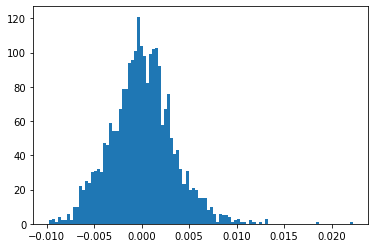

In [1311]:
plt.hist(list_std_score_median, bins = 100)
plt.tight_layout

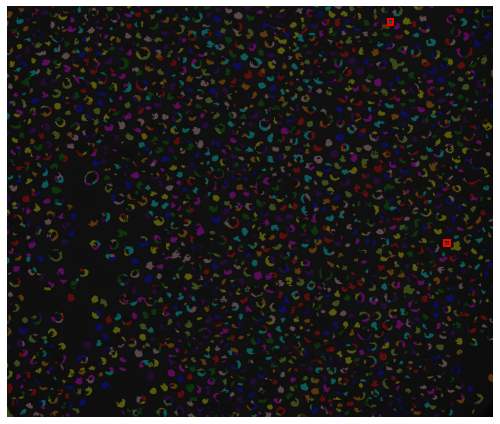

In [1312]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.std_median_center> .015:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

In [1144]:
region.bbox[0]

714

In [1138]:
plt.imshow(data_bfp_norm[region.coords[0][:, 0], region.coords[:, 1]])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

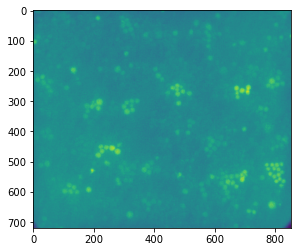

In [1120]:
plt.imshow(data_bfp_norm)

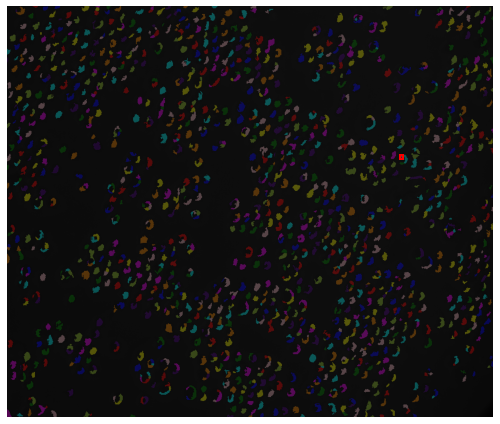

In [1129]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.intensity_mean[1]> .8:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

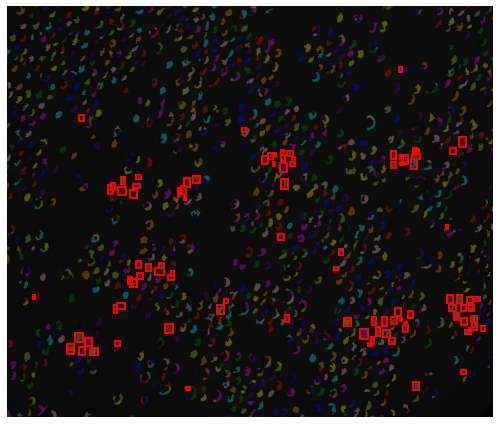

In [1054]:
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.tscore <= -60:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")
plt.show()
#plt.savefig("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output/BFP_positive.jpeg")

In [1122]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1_bfp.tif"
nucleus_area=(10,750)

list_cells_control_bfp_tmp = list_cells_control_bfp

control_dist = np.array(list_cells_control_bfp_tmp)


data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

blurred = gaussian_filter(data_control_mean_bfp, sigma=75)

data_bfp_norm = data_bfp[:,:] - blurred

data_bfp_norm = exposure.rescale_intensity(data_bfp_norm, in_range=(data_bfp_norm.min(), data_bfp_norm.max()), out_range=(0, 1))

corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    list_cells_control_bfp_tmp.append(score_intensityValue(region)[1])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)
    region.pval = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[1]
    region.tscore = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[0]

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


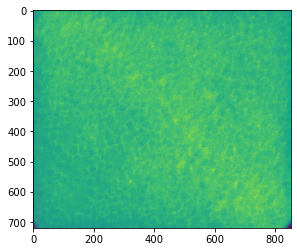

In [1124]:
plt.imshow(data_bfp_norm)

### Functions

In [ ]:
def props_measure(bright_path, bfp_path, nucleus_area):
    data = np.array(imread(bright_path)).astype(np.int16)
    data_bfp = np.array(imread(bfp_path)).astype(np.int16)
    
    corr_img = correlation_measure(data[:,:], data_bfp[:,:])
    corr_img = np.array(-corr_img* 1000).astype(np.int16)

    data = np.expand_dims(data, axis=2)
    data_bfp = np.expand_dims(data_bfp, axis=2)
    corr_img = np.expand_dims(corr_img, axis=2)

    combined_array = np.concatenate((data, data_bfp, corr_img), axis=2)
    
    intensity_image = combined_array[:,:]
    
    thresh = skimage.filters.threshold_otsu(data[:,:,0])
    
    cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
    props = skimage.measure.regionprops(cells, intensity_image = intensity_image)
    
    for region in props:
        b = region.bbox
        region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
        
    
    list_corr = []
    list_cell = []
    list_label = []
    list_intensity_bright =[]
    list_intensity_bfp = []
    list_intensity_corr = []
    
    score_label = lambda r: r.label
    score_intensityValue = lambda r: r.mean_intensity
    for region in props:
        list_cell.append(score_label(region))
        list_corr.append(correlate_channels(region,0, 1))
        list_label.append(bright_path.split("/")[-1].split(".")[0])
        list_intensity_bfp.append(score_intensityValue(region)[1])
        list_intensity_bright.append(score_intensityValue(region)[0])
        list_intensity_corr.append(score_intensityValue(region)[2])
    
    return (pd.DataFrame(zip(list_label, list_cell, list_corr, list_intensity_bright, list_intensity_bfp,
                             list_intensity_corr), columns = ["condition", "cell_number", "correlation_score", 
                                                              "mean_bright_intensity", "mean_bfp_intensity", "mean_corr_intensity"]))

In [ ]:
path_control1="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_1_bfp.tif"
path_control2="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_2_bfp.tif"
path_control3="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3_bfp.tif"
path_control4="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1_bfp.tif"
path_control5="/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_2_bfp.tif"
path_control6 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_3_bfp.tif"

data_control_1 = np.array(imread(path_control1)).astype(np.int16)
data_control_2 = np.array(imread(path_control2)).astype(np.int16)
data_control_3 = np.array(imread(path_control3)).astype(np.int16)
data_control_4 = np.array(imread(path_control4)).astype(np.int16)
data_control_5 = np.array(imread(path_control5)).astype(np.int16)
data_control_6 = np.array(imread(path_control6)).astype(np.int16)

data_control_mean = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

In [ ]:
list_bfp = [path_control1, path_control2, path_control3, path_control4, path_control5, path_control6]

In [1285]:
def process_background(list_bfp, sigma = 75):
    list_bfp_arrays = []
    for x in list_bfp:
        list_bfp_arrays.append(np.array(imread([x])).astype(np.int16))
    
    control_bfp = np.mean(list_bfp_arrays, axis = 0).astype(np.int16)
    control_bfp_norm = exposure.rescale_intensity(control_bfp, in_range=(control_bfp.min(), 
                                                                       control_bfp.max()), out_range=(0, 1))
    background = gaussian_filter(control_bfp_norm, sigma=sigma)
    
    return background

In [1287]:
bg = process_background(list_bfp, sigma = 75)

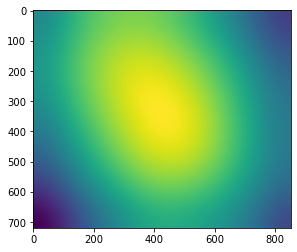

In [1289]:
plt.imshow(bg)
im = Image.fromarray(bg)
im.save("/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/output_std/background.tiff")

In [1313]:
def process_std_objects(path_bright, path_bfp, nucleus_area, background):

    data = np.array(imread(path)).astype(np.int16)
    data = np.expand_dims(data, axis=2)
    
    data_bfp = np.array(imread(path_2)).astype(np.int16)
    data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

    data_bfp_norm = data_bfp[:,:] - background
    data_bfp_norm = exposure.rescale_intensity(data_bfp_norm, in_range=(data_bfp_norm.min(), 
                                                                        data_bfp_norm.max()), out_range=(0, 1))
    data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)

    combined_array = np.concatenate((data, data_bfp_norm), axis=2)

    intensity_image = combined_array[:,:]

    thresh = skimage.filters.threshold_otsu(data[:,:,0])
    
    cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
    props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

    list_std = []

    list_cell = []
    list_label = []
    list_intensity_bright =[]
    list_intensity_bfp = []
    list_intensity_corr = []
    list_intensity_sub = []

    score_label = lambda r: r.label
    score_intensityValue = lambda r: r.mean_intensity

    for region in props:
        b = region.bbox
        border = 5
        ## Making new region properties
        region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
        region.std = np.std(intensity_image[b[0]-border:b[2]+border, b[1]-border:b[3]+border, 1])
        list_std.append(region.std)
        list_cell.append(score_label(region))
        list_label.append(path.split("/")[-1].split(".")[0])
        list_intensity_bfp.append(score_intensityValue(region)[1])

    std = np.array(list_std)
    cleaned_std = std[~np.isnan(std)]
    list_std_score_median =[]
    
    for region in props:
        region.std_median_center = region.std - np.median(cleaned_std)
        list_std_score_median.append(region.std_median_center)
    
    return (pd.DataFrame(zip(list_label, list_cell, list_std_score_median), columns = ["condition", "cell_number", 
                                                                                       "std_median_centered"]))

In [1316]:
df_12_1 = process_std_objects(path, path_2, nucleus_area, bg)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


In [1317]:
df_12_1

condition  cell_number  std_median_centered
0          6_1            1                  NaN
1          6_1            2                  NaN
2          6_1            3                  NaN
3          6_1            4                  NaN
4          6_1            5                  NaN
...        ...          ...                  ...
2489       6_1         2490            -0.002260
2490       6_1         2491            -0.000941
2491       6_1         2492            -0.000808
2492       6_1         2493            -0.003466
2493       6_1         2494             0.000815

[2494 rows x 3 columns]

In [1278]:
data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

In [1279]:
data_control_mean_bfp

array([[1626, 1561, 1589, ..., 1251, 1242, 1363],
       [1510, 1503, 1564, ..., 1263, 1326, 1292],
       [1531, 1510, 1512, ..., 1228, 1295, 1310],
       ...,
       [ 379,  424,  458, ...,  296,  285,  238],
       [ 400,  425,  411, ...,  305,  253,  239],
       [ 387,  437,  412, ...,  255,  246,  236]], dtype=int16)

In [ ]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/2/2_1_bfp.tif"
nucleus_area=(10,750)

list_cells_control_bfp_tmp = list_cells_control_bfp

control_dist = np.array(list_cells_control_bfp_tmp)


data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)

data_control_mean_bfp = np.mean([data_control_1, data_control_2, data_control_3, data_control_4,
                            data_control_5, data_control_6], axis = 0).astype(np.int16)

data_control_mean_bfp = exposure.rescale_intensity(data_control_mean_bfp, in_range=(data_control_mean_bfp.min(), 
                                                                       data_control_mean_bfp.max()), out_range=(0, 1))

data_bfp = exposure.rescale_intensity(data_bfp, in_range=(data_bfp.min(), data_bfp.max()), out_range=(0, 1))

blurred = gaussian_filter(data_control_mean_bfp, sigma=75)

data_bfp_norm = data_bfp[:,:] - blurred

data_bfp_norm = exposure.rescale_intensity(data_bfp_norm, in_range=(data_bfp_norm.min(), data_bfp_norm.max()), out_range=(0, 1))

corr_img = correlation_measure(data[:,:], data_bfp_norm[:,:])
corr_img = np.array(-corr_img* 1000).astype(np.int16)

sub_img = sub_measure(data[:,:], data_bfp_norm[:,:])

data = np.expand_dims(data, axis=2)
data_bfp_norm = np.expand_dims(data_bfp_norm[:,:], axis=2)
corr_img = np.expand_dims(corr_img, axis=2)
sub_img = np.expand_dims(sub_img, axis=2)

combined_array = np.concatenate((data, data_bfp_norm, corr_img, sub_img), axis=2)

intensity_image = combined_array[:,:]

thresh = skimage.filters.threshold_otsu(data[:,:,0])

cells = find_cell(data[:,:,0], thresh,area_min=nucleus_area[0], area_max=nucleus_area[1])
props = skimage.measure.regionprops(cells, intensity_image = intensity_image)

for region in props:
    b = region.bbox
    
    ## Making new region properties
    region.intensity_image_full = intensity_image[b[0]:b[2], b[1]:b[3], ...]
    region.correlation = correlate_channels(region,0, 1)


list_corr = []
list_cell = []
list_label = []
list_intensity_bright =[]
list_intensity_bfp = []
list_intensity_corr = []
list_intensity_sub = []

score_label = lambda r: r.label
score_intensityValue = lambda r: r.mean_intensity
for region in props:
    list_cell.append(score_label(region))
    list_corr.append(correlate_channels(region,0, 1))
    list_label.append(path.split("/")[-1].split(".")[0])
    list_intensity_bfp.append(score_intensityValue(region)[1])
    list_intensity_bright.append(score_intensityValue(region)[0])
    list_intensity_corr.append(score_intensityValue(region)[2])
    list_intensity_sub.append(score_intensityValue(region)[3])
    list_cells_control_bfp_tmp.append(score_intensityValue(region)[1])
    
for region in props:
    region.zscore = (score_intensityValue(region)[1] - np.mean(list_intensity_bfp))/np.std(list_intensity_bfp)
    region.pval = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[1]
    region.tscore = stats.ttest_1samp(list_intensity_bfp,score_intensityValue(region)[1])[0]

####  Z-score norming

#### Normalizing acorss images

In [556]:
from skimage import data, exposure

In [567]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
data_bfp = np.array(imread(path_2)).astype(np.int16)
data_bfp_norm = data_bfp[:,:] - data_control_mean_bfp

In [568]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_3.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_3_bfp.tif"
nucleus_area=(10,750)

data = np.array(imread(path)).astype(np.int16)
data_bfp_2 = np.array(imread(path_2)).astype(np.int16)
data_bfp_norm_2 = data_bfp_2[:,:] - data_control_mean_bfp

In [569]:
images = [data_bfp_norm,data_bfp_norm_2]

In [570]:
# Convert the list of images to a numpy array
images = np.array(images)

# Calculate the global minimum and maximum values across all images
min_val = np.min(images)
max_val = np.max(images)

# Normalize each image in the range [0, 1]
normalized_images = exposure.rescale_intensity(images, in_range=(min_val, max_val), out_range=(0, 1))


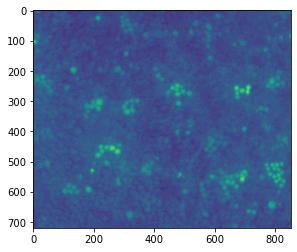

In [571]:
plt.imshow(normalized_images[0,:,:])

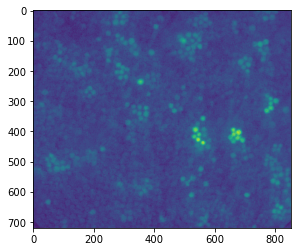

In [572]:
plt.imshow(normalized_images[1,:,:])

### Workspace

In [ ]:
corr_img = np.expand_dims(corr_img, axis=2)

In [245]:
combined_array = np.concatenate((data, data_bfp, corr_img), axis=2)

In [249]:
combined_array[:,:].shape

(720, 852, 3)

In [247]:
combined_array.shape

(720, 852, 3)

In [195]:
for region in props:
    region.correlation = correlate_channels(region,0, 1)

In [196]:
scores_corr = [region.correlation for region in props]

In [208]:
from skimage.color import label2rgb

In [215]:
threshold

0.2

In [216]:
# Step 5: Assign labels
threshold = .2  # Example threshold for positive cells
labels = ["Positive" if score < threshold else "Negative" for score in scores_corr]
# Step 6: Visualize the labeled cells
labeled_image = label2rgb(cells, image=data[:,:,0])
for label, region in zip(labels, props):
    y, x = region.centroid
    labeled_image = draw.text(labeled_image, (x, y), label)


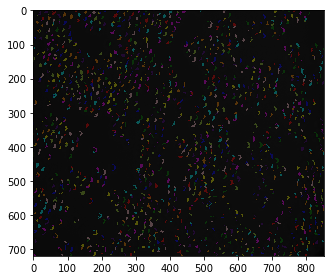

In [218]:
io.imshow(labeled_image)
io.show()

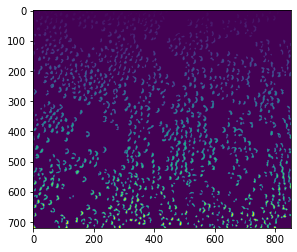

In [198]:
plt.imshow(cells)

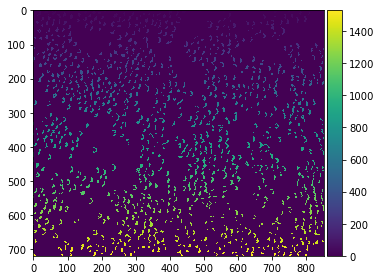

In [221]:
# Create a blank mask to draw the labeled cells
mask = np.zeros_like(cells)

# Draw rectangles or circles around the labeled cells
for prop, score in zip(props, scores_corr):
    if score < threshold:
        y, x = prop.centroid
        minr, minc, maxr, maxc = prop.bbox  # Bounding box coordinates

        # Draw rectangles
        # rect_coords = [(minc, minr), (maxc, maxr)]
        # rect_mask = draw.rectangle_perimeter(minr, minc, maxr, maxc)
        # mask[rect_mask] = [255, 0, 0]  # Set the rectangle color (red in this example)

        # Draw circles
        # radius = max(maxr - minr, maxc - minc) // 2
        # circle_mask = draw.circle_perimeter(int(y), int(x), radius)
        # mask[circle_mask] = [255, 0, 0]  # Set the circle color (red in this example)

# Overlay the labeled cells on the original image
overlay = np.where(mask > 0, mask, cells)

# Display the result
io.imshow(overlay)
io.show()

In [231]:
region.intensity_mean[1]

1655.7096774193549

NameError: name 'a' is not defined

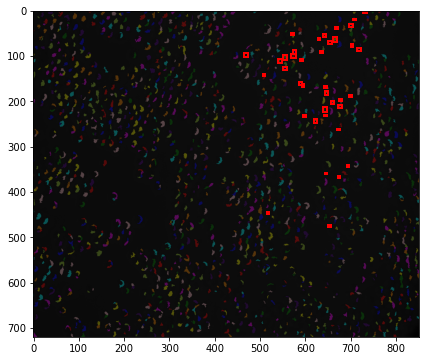

In [266]:
import matplotlib.patches as mpatches
threshold = 2200
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(cells, image=data[:,:,0], bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in props:
    # take regions with large enough areas
    if region.intensity_mean[0] >= threshold:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Processing Data

In [276]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/12/12_1_bfp.tif"
threshold = 1000
nucleus_area=(10,750)
df_cell_corr = props_measure(path, path_2, nucleus_area)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


In [259]:
df_cell_corr

condition  cell_number  correlation_score  mean_bright_intensity  \
0         12_3            1           0.472172            1904.909091   
1         12_3            2           0.947018            1966.764706   
2         12_3            3           0.897290            1995.117647   
3         12_3            4           0.962848            2031.759259   
4         12_3            5           0.966795            2088.050000   
...        ...          ...                ...                    ...   
1526      12_3         1527           0.947545            1973.962963   
1527      12_3         1528           0.723752            2008.833333   
1528      12_3         1529           0.223848            1879.916667   
1529      12_3         1530           0.703733            1755.823529   
1530      12_3         1531           0.104239            1636.193548   

      mean_bfp_intensity  mean_corr_intensity  
0            1999.909091          -848.454545  
1            2157.980392            51.313725  
2            2343.088235           775.205882  
3            2222.962963           249.851852  
4            2083.625000          -136.475000  
...                  ...                  ...  
1526         1918.074074          -981.518519  
1527         1921.375000          -809.250000  
1528         1851.666667         -1807.416667  
1529         1754.823529         -3376.411765  
1530         1655.709677         -5404.387097  

[1531 rows x 6 columns]

(array([  1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   2.,   1.,   3.,
          2.,   5.,   2.,   2.,   4.,   2.,   6.,   6.,   5.,  11.,   8.,
          6.,  10.,  12.,  18.,  15.,  11.,  16.,  22.,  26.,  28.,  27.,
         23.,  25.,  35.,  50.,  44.,  52.,  56.,  50.,  68.,  67.,  78.,
        100., 106., 127., 147., 153.,  96.]),
 array([-0.76381882, -0.72855777, -0.69329672, -0.65803567, -0.62277462,
        -0.58751357, -0.55225252, -0.51699146, -0.48173041, -0.44646936,
        -0.41120831, -0.37594726, -0.34068621, -0.30542516, -0.2701641 ,
        -0.23490305, -0.199642  , -0.16438095, -0.1291199 , -0.09385885,
        -0.0585978 , -0.02333674,  0.01192431,  0.04718536,  0.08244641,
         0.11770746,  0.15296851,  0.18822956,  0.22349062,  0.25875167,
         0.29401272,  0.32927377,  0.36453482,  0.39979587,  0.43505692,
         0.47031798,  0.50557903,  0.54084008,  0.57610113,  0.61136218,
         0.64662323,  0.68188428,  0.71714534,  0.75240639,  0.78766744,
 

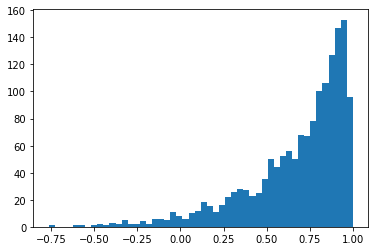

In [186]:
plt.hist(df_cell_corr.correlation_score, bins = 50)

In [193]:
df_cell_corr_1

condition  cell_number  correlation_score  mean_bright_intensity  \
0         1_3            1           0.977796            2004.400000   
1         1_3            2           0.985665            1866.409091   
2         1_3            3           0.983876            2019.818182   
3         1_3            4           0.890512            1846.028169   
4         1_3            5           0.803793            1713.690476   
..        ...          ...                ...                    ...   
934       1_3          935           0.979959            1981.117647   
935       1_3          936           0.974923            2010.733333   
936       1_3          937           0.997140            1393.333333   
937       1_3          938           0.993536            1972.500000   
938       1_3          939           0.977494            1901.700000   

     mean_bfp_intensity  
0           1531.250000  
1           1032.727273  
2           1331.000000  
3           1540.704225  
4           1580.321429  
..                  ...  
934         1316.117647  
935         1479.933333  
936          436.294118  
937         1124.916667  
938         1176.500000  

[939 rows x 5 columns]

In [187]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/1/1_3_bfp.tif"
threshold = 1000
nucleus_area=(10,750)
df_cell_corr_1 = props_measure(path, path_2, nucleus_area)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


In [188]:
df_cell_corr_1

condition  cell_number  correlation_score  mean_bright_intensity  \
0         1_3            1           0.977796            2004.400000   
1         1_3            2           0.985665            1866.409091   
2         1_3            3           0.983876            2019.818182   
3         1_3            4           0.890512            1846.028169   
4         1_3            5           0.803793            1713.690476   
..        ...          ...                ...                    ...   
934       1_3          935           0.979959            1981.117647   
935       1_3          936           0.974923            2010.733333   
936       1_3          937           0.997140            1393.333333   
937       1_3          938           0.993536            1972.500000   
938       1_3          939           0.977494            1901.700000   

     mean_bfp_intensity  
0           1531.250000  
1           1032.727273  
2           1331.000000  
3           1540.704225  
4           1580.321429  
..                  ...  
934         1316.117647  
935         1479.933333  
936          436.294118  
937         1124.916667  
938         1176.500000  

[939 rows x 5 columns]

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   4.,   0.,
          3.,   0.,   2.,   1.,   3.,   3.,   3.,   3.,   1.,   3.,   6.,
          2.,   5.,   7.,  10.,  13.,  15.,  13.,  20.,  23.,  25.,  47.,
         56.,  48., 104., 141., 209., 164.]),
 array([0.4686504 , 0.4792537 , 0.489857  , 0.50046029, 0.51106359,
        0.52166689, 0.53227019, 0.54287349, 0.55347678, 0.56408008,
        0.57468338, 0.58528668, 0.59588997, 0.60649327, 0.61709657,
        0.62769987, 0.63830316, 0.64890646, 0.65950976, 0.67011306,
        0.68071636, 0.69131965, 0.70192295, 0.71252625, 0.72312955,
        0.73373284, 0.74433614, 0.75493944, 0.76554274, 0.77614604,
        0.78674933, 0.79735263, 0.80795593, 0.81855923, 0.82916252,
        0.83976582, 0.85036912, 0.86097242, 0.87157571, 0.88217901,
        0.89278231, 0.90338561, 0.91398891, 0.9245922 , 0.9351955 ,
        0.9457988 , 0.9564021 , 0.96700539, 0.

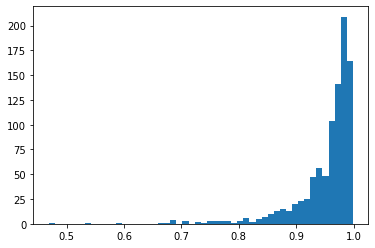

In [189]:
plt.hist(df_cell_corr_1.correlation_score, bins = 50)

In [190]:
path = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_1.resize.tif"
path_2 = "/Users/jakeqiu/Documents/mason/epigenome_reprogramming/crispr_screen/moi/Day_3/11/11_1_bfp.tif"
threshold = 1000
nucleus_area=(10,750)
df_cell_corr_4 = props_measure(path, path_2, nucleus_area)

/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:6: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  mean_filtered = skimage.filters.rank.mean(dapi, selem=selem)
/var/folders/j7/8z0g847j4tz5_d33ljs5p_nr0000gn/T/ipykernel_78864/3827173434.py:34: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


In [191]:
df_cell_corr_4

condition  cell_number  correlation_score  mean_bright_intensity  \
0         11_1            1           0.848984            2463.375000   
1         11_1            2           0.917627            2491.450000   
2         11_1            3           0.867300            2616.388889   
3         11_1            4           0.794186            2611.071429   
4         11_1            5           0.914310            2776.742857   
...        ...          ...                ...                    ...   
1576      11_1         1577           0.953133            2379.250000   
1577      11_1         1578           0.790683            2513.250000   
1578      11_1         1579           0.923007            2531.652174   
1579      11_1         1580           0.973856            2457.121212   
1580      11_1         1581           0.910542            2508.863636   

      mean_bfp_intensity  
0            2134.500000  
1            2188.250000  
2            2287.055556  
3            2430.428571  
4            2413.057143  
...                  ...  
1576         1966.000000  
1577         2325.200000  
1578         2136.478261  
1579         2088.848485  
1580         2244.681818  

[1581 rows x 5 columns]

(array([  2.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,   2.,   3.,   1.,
          6.,   1.,   1.,   2.,   3.,   3.,  12.,   5.,   6.,   5.,   9.,
          8.,   9.,   6.,  12.,  14.,  12.,   8.,  18.,  21.,  13.,  23.,
         31.,  15.,  31.,  35.,  33.,  44.,  36.,  58.,  71.,  66.,  81.,
         82.,  99., 136., 194., 199., 161.]),
 array([-0.63752884, -0.60484002, -0.5721512 , -0.53946238, -0.50677356,
        -0.47408474, -0.44139592, -0.4087071 , -0.37601828, -0.34332946,
        -0.31064064, -0.27795181, -0.24526299, -0.21257417, -0.17988535,
        -0.14719653, -0.11450771, -0.08181889, -0.04913007, -0.01644125,
         0.01624757,  0.04893639,  0.08162521,  0.11431403,  0.14700285,
         0.17969167,  0.21238049,  0.24506931,  0.27775814,  0.31044696,
         0.34313578,  0.3758246 ,  0.40851342,  0.44120224,  0.47389106,
         0.50657988,  0.5392687 ,  0.57195752,  0.60464634,  0.63733516,
         0.67002398,  0.7027128 ,  0.73540162,  0.76809044,  0.80077926,
 

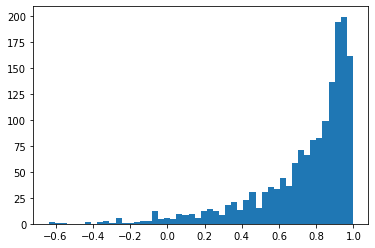

In [192]:
plt.hist(df_cell_corr_4.correlation_score, bins = 50)